In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploring and Modeling

In [3]:
df = pd.read_json('Data/OTL_textbooks_v0.json', orient='index')

print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 1523 entries, 1709 to 18
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   title                   1523 non-null   object             
 1   edition_statement       210 non-null    object             
 2   volume                  49 non-null     object             
 3   copyright_year          1491 non-null   float64            
 4   ISBN10                  19 non-null     float64            
 5   ISBN13                  632 non-null    object             
 6   license                 1523 non-null   object             
 7   language                1523 non-null   object             
 8   description             1523 non-null   object             
 9   contributors            1523 non-null   object             
 10  subjects                1523 non-null   object             
 11  publishers              1523 non-null   object 

,title,edition_statement,volume,copyright_year,ISBN10,ISBN13,license,language,description,contributors,subjects,publishers,formats,rating,textbook_reviews_count,reviews,url,updated_at
1709,Applications of Educational Technology,None,None,2018.0,NaN,None,Attribution-NonCommercial,eng,Welcome to the Applications of Educational Tec...,"[{'id': 7214, 'contribution': 'Author', 'prima...","[{'id': 5, 'name': 'Education', 'parent_subjec...","[{'id': 1683, 'name': 'Oklahoma State Universi...","[{'id': 4357, 'format': 'Online', 'url': 'http...",NaN,0,[],https://open.umn.edu/opentextbooks/textbooks/a...,2024-08-02 04:30:37+00:00
1708,Measurement and Instrumentation: An Introducti...,1st Edition,None,2020.0,NaN,None,Attribution-NonCommercial-ShareAlike,eng,Measurement and instrumentation are fundamenta...,"[{'id': 7212, 'contribution': 'Author', 'prima...","[{'id': 13, 'name': 'Engineering & Technology'...","[{'id': 1682, 'name': 'SHAREOK', 'url': 'https...","[{'id': 4356, 'format': 'PDF', 'url': 'https:/...",NaN,0,[],https://open.umn.edu/opentextbooks/textbooks/m...,2024-08-02 04:23:03+00:00


## Publishers columns

In [35]:
def get_publishers_df(df):
    return (df['publishers']
            .map(lambda x: [[c['id'], c['name'],] for c in x])
            .explode()
            .astype('str')
            .str
            .extract(r'(?P<id>\d+)\W+(?P<name>.+[^\'\]])')
)

In [36]:
df_pub = get_publishers_df(df)
print(df_pub.info())
df_pub.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 1524 entries, 1709 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1520 non-null   object
 1   name    1520 non-null   object
dtypes: object(2)
memory usage: 35.7+ KB
None


,id,name
1709,1683,Oklahoma State University
1708,1682,SHAREOK


In [37]:
df_pub.describe()

,id,name
count,1520,1520
unique,1520,399
top,1683,Editorial Grupo AEA
freq,1,65


**id** will be a property from the node property to the node book.

## Contributors column

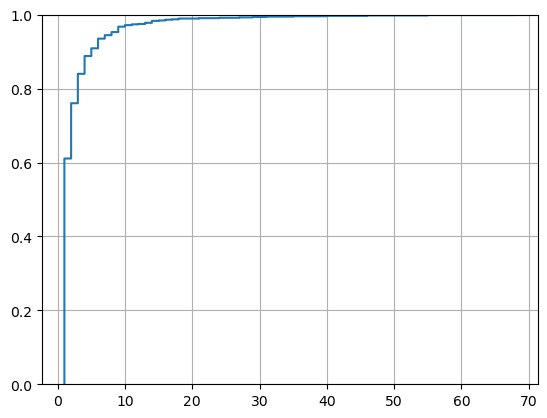

In [26]:
plt.ecdf(
    (df['contributors']
     .map(lambda x: [c['location'] for c in x])
     .explode()
     .value_counts()),
)
plt.grid()

plt.show()

In [110]:
(df['contributors']
 .map(lambda x: [[c['contribution'], c['primary'], c['corporate']] for c in x])
 .explode()
 .astype('str')
 .str.extract(r'\W+(?P<cont>\w+)\W+(?P<pr>\w+)\W+(?P<corp>\w+)')
 #.to_frame()
 #.value_counts()
 .pipe(lambda dtf: pd.crosstab(dtf.pr, dtf.corp, margins=True ))
 #.groupby(['pr', 'corp']).cont.count()
)

corp,False,True,All
pr,,,
False,2070,18,2088
True,957,6,963
All,3027,24,3051


In [5]:
def get_contributors_df(df):
    return (df['contributors']
            .map(lambda x: [[c['id'], c['contribution'], c['primary'], c['corporate'], c['location']] for c in x])
            .explode()
            .astype('str')
            .str
            .extract(r"(?P<id>\d+)\W+(?P<contribution>\w+)\W+(?P<primary>\w+)\W+(?P<corporate>\w+)\W+(?P<location>.+[^\'\]])")
            .replace({'location': r'None'}, value=np.nan)
           )

In [6]:
df_cont = get_contributors_df(df)

print(df_cont.info())
df_cont.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 3083 entries, 1709 to 18
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3051 non-null   object
 1   contribution  3051 non-null   object
 2   primary       3051 non-null   object
 3   corporate     3051 non-null   object
 4   location      2444 non-null   object
dtypes: object(5)
memory usage: 144.5+ KB
None


,id,contribution,primary,corporate,location
1709,7214,Author,False,False,Oklahoma State University
1708,7212,Author,False,False,University of Oklahoma


In [7]:
pd.crosstab(df_cont.contribution, df_cont.primary)

primary,False,True
contribution,,
Author,1829,921
Editor,244,42
Illustrator,12,0
Translator,3,0


In [50]:
df_cont.contribution.value_counts()

contribution
Author         2750
Editor          286
Illustrator      12
Translator        3
Name: count, dtype: int64

In [49]:
df_cont.describe()

,id,contribution,primary,corporate,location
count,3051,3051,3051,3051,2444
unique,3051,4,2,2,955
top,7214,Author,False,False,Universidad Nacional de Huancavelica
freq,1,2750,2088,3027,68


**Author**, **Editor**, **Primary** and **Corporate** will be labels, but I will leave contribution as a property too. **Location** will be a node.

## Formats column

In [48]:
(df['formats']
 .map(lambda x: [c['id'] for c in x if c['format']=='PDF'])
 .explode()
 .value_counts() > 1
).any()

False

The **format.id** will be a property in the relation to the node **format**.

## Subjects column

In [54]:
(df['subjects']
 .map(lambda x: [c['id'] for c in x if c['name']=='Mathematics'])
 .explode()
 .value_counts()
)

subjects
7    140
Name: count, dtype: int64

## Reviews column

In [14]:
def get_reviews_df(df):
    return (df['reviews']
            .map(lambda x: [[c['id'], c['institution_name'],] for c in x])
            .explode()
            .astype('str')
            .str
            .extract(r"(?P<id>\d+)\W+(?P<inst_name>.+[^\'\]])")
            .dropna(how='all')
           )

In [15]:
df_rev = get_reviews_df(df)
print(df_rev.info())
df_rev.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 6817 entries, 1693 to 18
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         6817 non-null   object
 1   inst_name  6817 non-null   object
dtypes: object(2)
memory usage: 159.8+ KB
None


,id,inst_name
1693,35192,Grace College and Seminary
1686,35181,Anderson University


In [16]:
df_rev.describe()

,id,inst_name
count,6817,6817
unique,6817,874
top,35192,Portland Community College
freq,1,205


In [28]:
df_cont[df_cont.location == df_rev.inst_name.value_counts().index[0]]

,id,contribution,primary,corporate,location
1688,7158,Author,False,False,Portland Community College
1688,7159,Author,False,False,Portland Community College
1688,7160,Author,False,False,Portland Community College
1533,6676,Author,True,False,Portland Community College
1430,6294,Author,True,False,Portland Community College
999,5418,Author,False,False,Portland Community College
944,5327,Author,False,False,Portland Community College
888,5236,Author,False,False,Portland Community College
700,4839,Author,False,False,Portland Community College
699,4838,Author,False,False,Portland Community College


This is a **review** node, not **reviewer** and there is some overlep between rev.intitute_name and contributors.location , but I will leave them as two distinct nodes. Maybe in future versions I change.

# Creating...

## Constraints

Just execute the cypher code substituing name with book, publisher, review, contributor and subject each time.

Like this.

Now besides format do the same with language, license, location and institute

## Loading